<a href="https://colab.research.google.com/github/RamilyaKo/-RamilyaKo-s-Repository/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_Covid_19_forecasting_for_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://docs.google.com/presentation/d/1saje6afyxejTteqX_8We6clHIm23AsZd/edit?usp=sharing&ouid=106913776734034605970&rtpof=true&sd=true

Аттестационная работа

Covid-19 forecasting
COVID-19 - это вызывающий заболевание штамм коронавируса, появившийся в декабре 2019 года и приведший к продолжающейся глобальной пандемии. Возможность предвидеть путь пандемии имеет решающее значение. Это важно для того, чтобы определить, как бороться, и отследить его распространение.

Введение. Постановка целей и задач.
Провести анализ данных о заболеваемости, предложить и настроить прогностическую модель, выполнить прогноз и сравнить результаты с новой статистикой (полученной после 5 апреля 2021 года)

Задача: провести анализ данных о заболеваемости, предложить и настроить прогностическую модель, выполнить прогноз и сравнить результаты с новой статистикой (полученной после 5 апреля 2021 года).

Импортируем библиотеки, скачиваем realtime data по ссылке  https://github.com/owid/covid-19-data/tree/master/public/data 

In [ ]:
!pip install nbconvert
import nbconvert
!pip install pmdarima
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima  
from pandas.plotting import lag_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

url = 'https://drive.google.com/file/d/16W2HAMywdXKK4AA9yr6ufMciJ_4D2QwJ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_csv(path, delimiter=',' )

Знакомимся с данными с помощью функций head, count, info

In [ ]:
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [ ]:
df.count()

iso_code                                   148106
continent                                  139164
location                                   148106
date                                       148106
total_cases                                145506
                                            ...  
human_development_index                    121559
excess_mortality_cumulative_absolute         5050
excess_mortality_cumulative                  5050
excess_mortality                             5050
excess_mortality_cumulative_per_million      5050
Length: 67, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148106 entries, 0 to 148105
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    148106 non-null  object 
 1   continent                                   139164 non-null  object 
 2   location                                    148106 non-null  object 
 3   date                                        148106 non-null  object 
 4   total_cases                                 145506 non-null  float64
 5   new_cases                                   145500 non-null  float64
 6   new_cases_smoothed                          144355 non-null  float64
 7   total_deaths                                128558 non-null  float64
 8   new_deaths                                  128754 non-null  float64
 9   new_deaths_smoothed                         144355 non-null  float64
 

Предобработка данных: нам даны 67 колонок данных по 160 странам, чтобы провести анализ данных и сделать прогноз ситуации по covid-19 - сделаем выборку данных по одной стране (Италии)

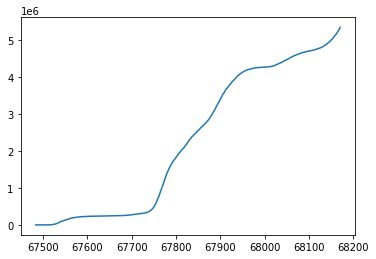

In [ ]:
df[df.location=='Italy'].total_cases.plot()

In [ ]:
df_lim = df[df.location=='Italy']
df_lim

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
67484,ITA,Europe,Italy,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,0.033,0.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN
67485,ITA,Europe,Italy,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,0.033,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN
67486,ITA,Europe,Italy,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,0.033,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,-6878.1,-9.02,-6.19,-113.93719
67487,ITA,Europe,Italy,2020-02-03,2.0,0.0,NaN,NaN,NaN,NaN,0.033,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN
67488,ITA,Europe,Italy,2020-02-04,2.0,0.0,NaN,NaN,NaN,NaN,0.033,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68166,ITA,Europe,Italy,2021-12-13,5238221.0,12704.0,17092.143,134929.0,98.0,91.714,86772.245,210.444,283.135,2235.128,1.623,1.519,1.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313536.0,126306054.0,2092.287,5.194,524197.0,8.683,0.0326,30.7,tests performed,102642259.0,47672920.0,44320415.0,12147751.0,517306.0,470497.0,170.03,78.97,73.42,20.12,7794.0,32693.0,0.054,76.85,60367471.0,205.859,47.9,23.021,16.24,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN
68167,ITA,Europe,Italy,2021-12-14,5258886.0,20665.0,17795.429,135049.0,120.0,94.714,87114.565,342.320,294.785,2237.115,1.988,1.569,1.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,776563.0,127082617.0,2105.151,12.864

Удалим малоинформативные колонки данных, и оставим 5 наиболее важных для анализа и построения моделей прогнозирования:
- дата 
- общее количество случаев
- новые случаи заболеваний
- общее количество смертности
- новые случаи смертности


In [ ]:
df_lim2 = df_lim[['date',	'total_cases',	'new_cases',	'total_deaths',	'new_deaths']]
df_lim2

,date,total_cases,new_cases,total_deaths,new_deaths
67484,2020-01-31,2.0,2.0,NaN,NaN
67485,2020-02-01,2.0,0.0,NaN,NaN
67486,2020-02-02,2.0,0.0,NaN,NaN
67487,2020-02-03,2.0,0.0,NaN,NaN
67488,2020-02-04,2.0,0.0,NaN,NaN
...,...,...,...,...,...
68166,2021-12-13,5238221.0,12704.0,134929.0,98.0
68167,2021-12-14,5258886.0,20665.0,135049.0,120.0
68168,2021-12-15,5282076.0,23190.0,135178.0,129.0
68169,2021-12-16,5308180.0,26104.0,135301.0,123.0


выявим и устраним пропуски

In [ ]:
df_lim2.isnull().sum()

date             0
total_cases      0
new_cases        0
total_deaths    21
new_deaths      21
dtype: int64

In [ ]:
df1 = df_lim2.fillna(0)
df1

,date,total_cases,new_cases,total_deaths,new_deaths
67484,2020-01-31,2.0,2.0,0.0,0.0
67485,2020-02-01,2.0,0.0,0.0,0.0
67486,2020-02-02,2.0,0.0,0.0,0.0
67487,2020-02-03,2.0,0.0,0.0,0.0
67488,2020-02-04,2.0,0.0,0.0,0.0
...,...,...,...,...,...
68166,2021-12-13,5238221.0,12704.0,134929.0,98.0
68167,2021-12-14,5258886.0,20665.0,135049.0,120.0
68168,2021-12-15,5282076.0,23190.0,135178.0,129.0
68169,2021-12-16,5308180.0,26104.0,135301.0,123.0


In [ ]:
df1.duplicated()

67484    False
67485    False
67486    False
67487    False
67488    False
         ...  
68166    False
68167    False
68168    False
68169    False
68170    False
Length: 687, dtype: bool

Пропуски устранены, дубликаты не обнаружены.

EDA или разведочный анализ данных.

Определяем ключевым столбцом (index) дату стат. показателей в Df1, т.к. далее будем работать с временными рядами, а также меняем тип данных (time) в указанном столбце на подходящий нам для дальнейшей работы

In [ ]:
df1['date']=df1['date'].astype('datetime64')
df1.index=df1.date
df1.info()
df1

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 687 entries, 2020-01-31 to 2021-12-17
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          687 non-null    datetime64[ns]
 1   total_cases   687 non-null    float64       
 2   new_cases     687 non-null    float64       
 3   total_deaths  687 non-null    float64       
 4   new_deaths    687 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 32.2 KB


,date,total_cases,new_cases,total_deaths,new_deaths
date,,,,,
2020-01-31,2020-01-31,2.0,2.0,0.0,0.0
2020-02-01,2020-02-01,2.0,0.0,0.0,0.0
2020-02-02,2020-02-02,2.0,0.0,0.0,0.0
2020-02-03,2020-02-03,2.0,0.0,0.0,0.0
2020-02-04,2020-02-04,2.0,0.0,0.0,0.0
...,...,...,...,...,...
2021-12-13,2021-12-13,5238221.0,12704.0,134929.0,98.0
2021-12-14,2021-12-14,5258886.0,20665.0,135049.0,120.0
2021-12-15,2021-12-15,5282076.0,23190.0,135178.0,129.0


Выведем основную статистику

In [ ]:
df1.describe()

,total_cases,new_cases,total_deaths,new_deaths
count,6.870000e+02,687.000000,687.000000,687.000000
mean,2.274448e+06,7768.260553,76081.400291,197.119360
std,1.919088e+06,8561.399646,46913.136239,225.664559
min,2.000000e+00,-148.000000,0.000000,-31.000000
25%,2.446880e+05,1215.000000,35065.500000,24.000000
50%,2.237890e+06,4254.000000,77911.000000,71.000000
75%,4.258794e+06,12937.000000,127521.000000,347.500000
max,5.336795e+06,40902.000000,135421.000000,993.000000


Стат.показатель 'mean' показывает, что среднее значение новых случаев заболеваний составляет 7768, а количество новых смертельных случаев ежедневно составляет 197.

Стат.показатель 'max' показывает, что ежедневно выявляется до 40.902 случаев заболеваний, а смертность составляет максимум 993.


Построим графики новых случаев заболеваний и новых смертельных случаев, посмотрим на их корреляцию.

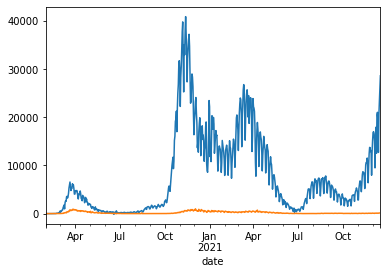

In [ ]:
df1.new_cases.plot()
df1.new_deaths.plot()

In [ ]:
df1.corr()

,total_cases,new_cases,total_deaths,new_deaths
total_cases,1.000000,0.190604,0.986076,-0.133710
new_cases,0.190604,1.000000,0.182424,0.612691
total_deaths,0.986076,0.182424,1.000000,-0.151847
new_deaths,-0.133710,0.612691,-0.151847,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24c9bb9ad0>,
      dtype=object)

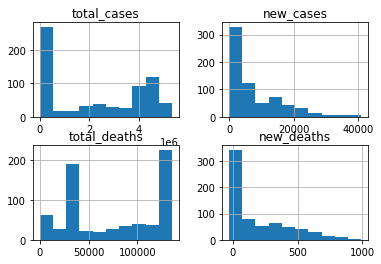

In [ ]:
df1.hist()

на пересечении new_cases и new_deaths 0.61 наблюдается корреляция

Text(0.5, 1.0, 'Новые случаи смертности')

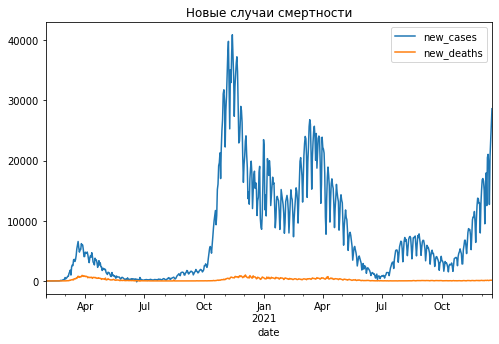

In [ ]:
df1.new_cases.plot(figsize=(8,5) , legend=True)
plt.title("Новые случаи заболеваний") 
df1.new_deaths.plot(figsize=(8,5) , legend=True)
plt.title("Новые случаи смертности") 

Для построения моделей и прогнозирования результатов используем: 
SARIMA и Экспоненциальную модель Holt-Winters' Model

 Выполним ETS декомпозицию, используя аддитивную модель ('additive').

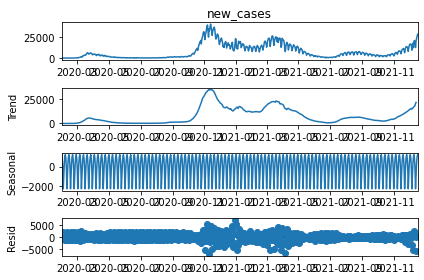

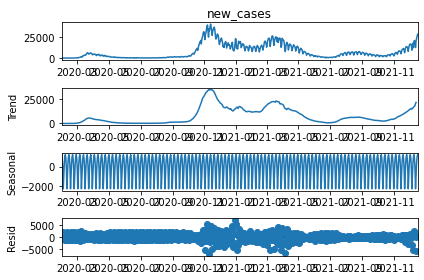

In [ ]:
df2 = seasonal_decompose(df1['new_cases'], model='additive')
df2.plot()

Для определения значения факторов (p,d,q)(P,D,Q)s воспользуемся auto_arima:

In [ ]:
auto_arima(df1['new_cases'], seasonal=True, m=2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  687
Model:             SARIMAX(1, 1, 0)x(2, 0, [1, 2], 2)   Log Likelihood               -6061.543
Date:                                Mon, 20 Dec 2021   AIC                          12137.086
Time:                                        22:42:18   BIC                          12168.802
Sample:                                             0   HQIC                         12149.358
                                                - 687                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     49.0456    145.381      0.337      0.736    -235.895     333.986
ar.L1         -0.3065      0.022    -14.135      0.000      -0.349      -0.264
ar.S.L2       -0.4382      0.007    -64.461      0.000      -0.452      -0.425
ar.S.L4       -0.9972      0.003   -304.316      0.000      -1.004      -0.991
ma.S.L2        0.2665      0.017     16.150      0.000       0.234       0.299
ma.S.L4        0.8231      0.016     51.722      0.000       0.792       0.854
sigma2      2.781e+06   8.43e+04     32.988      0.000    2.62e+06    2.95e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.41   Jarque-Bera (JB):              1020.22
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):              19.59   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.16e+14. Standard errors may be unstable.
"""

In [ ]:
df1.index.freq = 'D'
print(len(df1))
print(df1.head())

687
                 date  total_cases  new_cases  total_deaths  new_deaths
date                                                                   
2020-01-31 2020-01-31          2.0        2.0           0.0         0.0
2020-02-01 2020-02-01          2.0        0.0           0.0         0.0
2020-02-02 2020-02-02          2.0        0.0           0.0         0.0
2020-02-03 2020-02-03          2.0        0.0           0.0         0.0
2020-02-04 2020-02-04          2.0        0.0           0.0         0.0


Установим 10 дней для тестирования. 

In [ ]:
train = df1.iloc[:len(df1)-10]
test = df1.iloc[len(df1)-10:]

In [ ]:
model = SARIMAX(train['new_cases'], order=(1, 0, 1), seasonal_order=(2, 1, [1,2], 2) )
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              new_cases   No. Observations:                  677
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 2)   Log Likelihood               -5957.469
Date:                                Mon, 20 Dec 2021   AIC                          11928.939
Time:                                        22:42:21   BIC                          11960.542
Sample:                                    01-31-2020   HQIC                         11941.176
                                         - 12-07-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.029     -4.430      0.000      -0.183      -0.071
ma.L1          1.0000      0.037     26.745      0.000       0.927       1.073
ar.S.L2       -0.4309      0.009    -45.577      0.000      -0.449      -0.412
ar.S.L4       -0.9989      0.002   -634.480      0.000      -1.002      -0.996
ma.S.L2        0.2210      0.018     11.947      0.000       0.185       0.257
ma.S.L4        0.8314      0.018     45.109      0.000       0.795       0.868
sigma2      3.251e+06   1.15e-08   2.83e+14      0.000    3.25e+06    3.25e+06
===================================================================================
Ljung-Box (L1) (Q):                  24.05   Jarque-Bera (JB):              1182.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.49   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.09e+28. Standard errors may be unstable.
"""

Получили прогнозируемые значения

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(0, 1, 0)x(2, 0, [0], 12)')

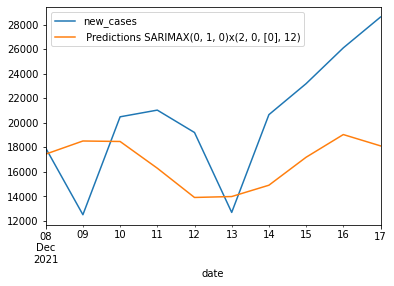

In [ ]:
test['new_cases'].plot(legend=True)
predictions.plot(legend=True)

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 12)')

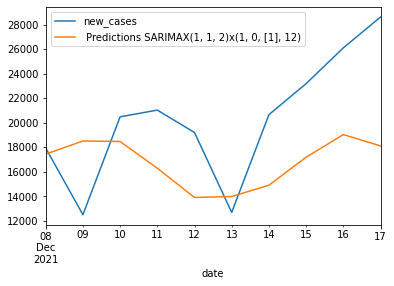

In [ ]:
test['new_cases'].plot(legend=True)
predictions.plot(legend=True)

выводим первые 5 значений для test, predictions и train

In [ ]:
predictions.head()

2021-12-08    17450.630906
2021-12-09    18520.073983
2021-12-10    18480.644254
2021-12-11    16304.078762
2021-12-12    13921.109622
Freq: D, Name:  Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 12), dtype: float64

In [ ]:
test['new_cases'].head()

date
2021-12-08    17946.0
2021-12-09    12516.0
2021-12-10    20490.0
2021-12-11    21035.0
2021-12-12    19212.0
Freq: D, Name: new_cases, dtype: float64

In [ ]:
train['new_cases'].head()

date
2020-01-31    2.0
2020-02-01    0.0
2020-02-02    0.0
2020-02-03    0.0
2020-02-04    0.0
Freq: D, Name: new_cases, dtype: float64

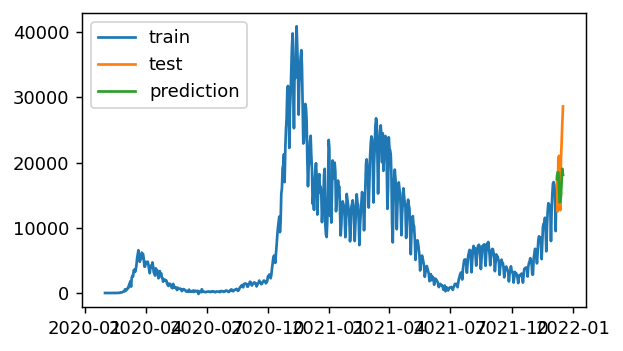

In [ ]:
plt.figure(figsize=(5,3), dpi=130)
plt.plot(train['new_cases'], label='train')
plt.plot(test['new_cases'], label='test')
plt.plot(predictions, label='prediction')
plt.legend()
plt.show()

Оценим качество модели SARIMA с помощью MAE, MAPE и MSE 

In [ ]:
print('Расчет точности полученного прогноза')
print('MAE:', mean_absolute_error(test['new_cases'], predictions))
print('MAPE:', mean_absolute_percentage_error(test['new_cases'], predictions))
print('MSE:', mean_squared_error(test['new_cases'], predictions))

Расчет точности полученного прогноза
MAE: 4911.467845944241
MAPE: 0.23810462171031804
MSE: 32124489.872745417


В целом, модель прогнозирования на 10 дней подтверждает, что волна новых заболеваний и случаев смертности ещё не закончилась.

Экспоненциальное сглаживание - модель Хольта-Винтера (Holt-Winters' Model)

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions_hw = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1, 0, 0)x(0, 1, [1,2], 2) ')
predictions_hw

2021-12-08    17450.630906
2021-12-09    18520.073983
2021-12-10    18480.644254
2021-12-11    16304.078762
2021-12-12    13921.109622
2021-12-13    13996.356764
2021-12-14    14918.671843
2021-12-15    17196.365929
2021-12-16    19044.500575
2021-12-17    18122.750398
Freq: D, Name: SARIMA(1, 0, 0)x(0, 1, [1,2], 2) , dtype: float64

In [ ]:
model_hw = ExponentialSmoothing(train['new_cases'], trend='add',seasonal='add',seasonal_periods=2).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
predictions_hw = model_hw.predict(start=start, end=end)

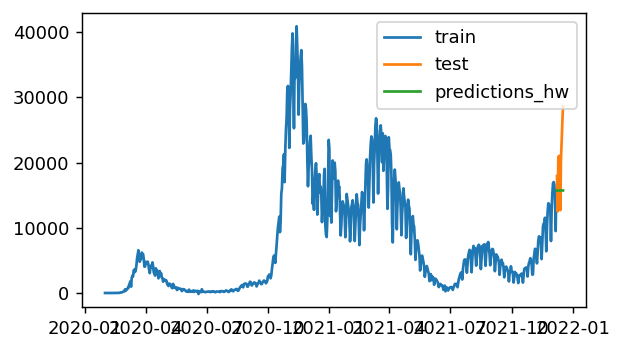

In [ ]:
plt.figure(figsize=(5,3), dpi=130)
plt.plot(train['new_cases'], label='train')
plt.plot(test['new_cases'], label='test')
plt.plot(predictions_hw, label='predictions_hw')
plt.legend()
plt.show()

Оценим качество модели Хольта-Винтера с помощью MAE, MAPE и MSE 

In [ ]:
print('Рассчет точности полученного прогноза')
print('MAE:', mean_absolute_error(test['new_cases'], predictions_hw))
print('MAPE:', mean_absolute_percentage_error(test['new_cases'], predictions_hw))
print('MSE:', mean_squared_error(test['new_cases'], predictions_hw))

Рассчет точности полученного прогноза
MAE: 5772.772040200725
MAPE: 0.2695049734802351
MSE: 44180412.21856908


Модель Хольта-Винтера показала большую погрешность прогнозирования, чем модель SARIMAX. Значит, в данном случае надо опираться на данные модели SARIMAX.
